<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,matplotlib,scipy,pandas,sklearn,mlxtend

last updated: 2017-03-29 

CPython 2.7.10
IPython 5.3.0

numpy 1.12.0
matplotlib 2.0.0
scipy 0.15.1
pandas 0.19.2
sklearn 0.18.1
mlxtend 0.5.1


# Cosmic-ray composition effective area analysis
### Table of contents
1. [Load simulation DataFrame and apply quality cuts](#Load-simulation-DataFrame-and-apply-quality-cuts)
2. [Define functions to be fit to effective area](#Define-functions-to-be-fit-to-effective-area)
3. [Calculate effective areas](#Calculate-effective-areas)
4. [Plot result](#Plot-result)

In [2]:
%matplotlib inline
from __future__ import division, print_function
from collections import defaultdict
import numpy as np
from scipy import optimize
from scipy.stats import chisquare
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns

import composition as comp

color_dict = comp.analysis.get_color_dict()

/home/jbourbeau/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load simulation DataFrame and apply quality cuts
[ [back to top](#top) ]

In [3]:
df_sim, cut_dict_sim = comp.load_dataframe(datatype='sim', config='IC79', return_cut_dict=True)
selection_mask = np.array([True] * len(df_sim))
standard_cut_keys = ['IceTopQualityCuts', 'lap_InIce_containment',
#                 'num_hits_1_60', 'max_qfrac_1_60',
                'InIceQualityCuts', 'num_hits_1_60']
# for cut in ['MilliNCascAbove2', 'MilliQtotRatio', 'MilliRloglBelow2', 'StochRecoSucceeded']:
#     standard_cut_keys += ['InIceQualityCuts_{}'.format(cut)]
    
for key in standard_cut_keys:
    selection_mask *= cut_dict_sim[key]
    print(key, np.sum(selection_mask))

df_sim = df_sim[selection_mask]

/home/jbourbeau/cr-composition/composition/dataframe_functions.py:137: RuntimeWarning: divide by zero encountered in log10
  df['log_dEdX'] = np.log10(df['eloss_1500_standard'])
/home/jbourbeau/cr-composition/composition/dataframe_functions.py:137: RuntimeWarning: invalid value encountered in log10
  df['log_dEdX'] = np.log10(df['eloss_1500_standard'])


IceTopQualityCuts 398044
lap_InIce_containment 308917
InIceQualityCuts 298476
num_hits_1_60 298466


#### Define energy binning for this analysis

In [4]:
log_energy_bins = np.arange(5.0, 9.51, 0.1)
energy_bins = 10**log_energy_bins
energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2

energy_min_fit, energy_max_fit = 5.8, 9.5
midpoints_fitmask = (energy_midpoints >= 10**energy_min_fit) & (energy_midpoints <= 10**energy_max_fit)

In [5]:
log_energy_bins

array([ 5. ,  5.1,  5.2,  5.3,  5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,
        6.1,  6.2,  6.3,  6.4,  6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,
        7.2,  7.3,  7.4,  7.5,  7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,
        8.3,  8.4,  8.5,  8.6,  8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,
        9.4,  9.5])

In [6]:
np.log10(energy_midpoints[midpoints_fitmask])

array([ 5.8528719,  5.9528719,  6.0528719,  6.1528719,  6.2528719,
        6.3528719,  6.4528719,  6.5528719,  6.6528719,  6.7528719,
        6.8528719,  6.9528719,  7.0528719,  7.1528719,  7.2528719,
        7.3528719,  7.4528719,  7.5528719,  7.6528719,  7.7528719,
        7.8528719,  7.9528719,  8.0528719,  8.1528719,  8.2528719,
        8.3528719,  8.4528719,  8.5528719,  8.6528719,  8.7528719,
        8.8528719,  8.9528719,  9.0528719,  9.1528719,  9.2528719,
        9.3528719,  9.4528719])

### Define functions to be fit to effective area

In [7]:
def constant(energy, c):
    return c

def linefit(energy, m, b):
    return m*np.log10(energy) + b

def sigmoid_flat(energy, p0, p1, p2):
    return p0 / (1 + np.exp(-p1*np.log10(energy) + p2))

def sigmoid_slant(energy, p0, p1, p2, p3):
    return (p0 + p3*np.log10(energy)) / (1 + np.exp(-p1*np.log10(energy) + p2))

In [8]:
def red_chisquared(obs, fit, sigma, n_params):
    return np.sum(((obs - fit)/sigma) ** 2) / (len(obs) - n_params)
#     return np.sum(((obs - fit)/sigma) ** 2) / (len(obs) - 1 - n_params)

In [9]:
np.sum(midpoints_fitmask)-3

34

### Calculate effective areas

In [10]:
eff_area, eff_area_error = comp.analysis.effective_area.effective_area(df_sim, log_energy_bins)
eff_area_light, eff_area_error_light = comp.analysis.effective_area.effective_area(df_sim[df_sim.MC_comp_class == 'light'], log_energy_bins)
eff_area_heavy, eff_area_error_heavy = comp.analysis.effective_area.effective_area(df_sim[df_sim.MC_comp_class == 'heavy'], log_energy_bins)

[ 7.00561438  7.00561438  7.00561438 ...,  7.72806866  7.72806866
  7.84396691]
[ 94.57502884  94.57502884  94.57502884 ...,  45.39601384  45.39601384
  45.39601384]
[ 7.00561438  7.00561438  7.00561438 ...,  5.99320701  5.99320701
  5.99320701]
[ 94.57502884  94.57502884  94.57502884 ...,  20.10619298  20.10619298
  20.10619298]
[ 7.10245765  7.10245765  7.10245765 ...,  7.72806866  7.72806866
  7.84396691]
[ 94.57502884  94.57502884  94.57502884 ...,  45.39601384  45.39601384
  45.39601384]


In [12]:
eff_area, eff_area_error, _ = comp.analysis.get_effective_area(df_sim,
                                                                energy_bins, energy='MC')
eff_area_light, eff_area_error_light, _ = comp.analysis.get_effective_area(
                                                                df_sim[df_sim.MC_comp_class == 'light'],
                                                                energy_bins, energy='MC')
eff_area_heavy, eff_area_error_heavy, _ = comp.analysis.get_effective_area(
                                                                df_sim[df_sim.MC_comp_class == 'heavy'],
                                                                energy_bins, energy='MC')

Calculating effective area...
Simulation set 7006: 30000 files
Simulation set 7007: 30000 files
Simulation set 7241: 10000 files
Simulation set 7242: 10000 files
Simulation set 7262: 19999 files
Simulation set 7263: 19998 files
Simulation set 7579: 12000 files
Simulation set 7784: 12000 files
Simulation set 7791: 12000 files
Simulation set 7851: 12000 files
Calculating effective area...
Simulation set 7006: 30000 files
Simulation set 7241: 10000 files
Simulation set 7263: 19998 files
Simulation set 7579: 12000 files
Simulation set 7791: 12000 files
Calculating effective area...
Simulation set 7007: 30000 files
Simulation set 7242: 10000 files
Simulation set 7262: 19999 files
Simulation set 7784: 12000 files
Simulation set 7851: 12000 files


In [11]:
eff_area_light

array([  0.00000000e+00,   1.00530965e+01,   1.30694276e+02,
         9.24897948e+02,   3.18693112e+03,   1.00835333e+04,
         2.16651458e+04,   4.80955961e+04,   7.31789979e+04,
         1.06867870e+05,   1.15849101e+05,   1.28090224e+05,
         1.43371852e+05,   1.44417323e+05,   1.41395120e+05,
         1.38943330e+05,   1.45462509e+05,   1.39912596e+05,
         1.44949720e+05,   1.36833221e+05,   1.36428818e+05,
         1.38028766e+05,   1.44354269e+05,   1.47696527e+05,
         1.45224459e+05,   1.42882565e+05,   1.43253520e+05,
         1.39929978e+05,   1.48188063e+05,   1.43497246e+05,
         1.43350873e+05,   1.51536031e+05,   1.38705243e+05,
         1.53527015e+05,   1.45563078e+05,   1.45120637e+05,
         1.47111621e+05,   1.23219809e+05,   1.39590125e+05,
         1.49987487e+05,   1.40360469e+05,   1.56047816e+05,
         1.46690451e+05,   1.45039152e+05,   1.22196173e+05])

#### Fit functions to effective area data

In [12]:
p0 = [1.4e5, 8.0, 50.0]
popt_light, pcov_light = optimize.curve_fit(sigmoid_flat, energy_midpoints[midpoints_fitmask],
                                            eff_area_light[midpoints_fitmask], p0=p0,
                                            sigma=eff_area_error_light[midpoints_fitmask])
popt_heavy, pcov_heavy = optimize.curve_fit(sigmoid_flat, energy_midpoints[midpoints_fitmask],
                                            eff_area_heavy[midpoints_fitmask], p0=p0,
                                            sigma=eff_area_error_heavy[midpoints_fitmask])

In [13]:
print(popt_light)
print(popt_heavy)

[  1.42310223e+05   8.59758980e+00   5.02313289e+01]
[  1.44043593e+05   7.72100146e+00   4.58503628e+01]


In [14]:
perr_light = np.sqrt(np.diag(pcov_light))
print(perr_light)
perr_heavy = np.sqrt(np.diag(pcov_heavy))
print(perr_heavy)

[  9.55907938e+02   6.58725783e-01   3.87702597e+00]
[  7.77422331e+02   2.95650806e-01   1.74795977e+00]


In [15]:
avg = (popt_light[0] + popt_heavy[0]) / 2
print('avg eff area = {}'.format(avg))

avg eff area = 143176.908047


In [16]:
light_chi2 = red_chisquared(eff_area_light[midpoints_fitmask],
               sigmoid_flat(energy_midpoints[midpoints_fitmask], *popt_light),
               eff_area_error_light[midpoints_fitmask], len(popt_light))
print(light_chi2)
heavy_chi2 = red_chisquared(eff_area_heavy[midpoints_fitmask],
               sigmoid_flat(energy_midpoints[midpoints_fitmask], *popt_heavy),
               eff_area_error_heavy[midpoints_fitmask], len(popt_heavy))
print(heavy_chi2)

4.54570904496
2.75141874206


### Plot result

1431.77


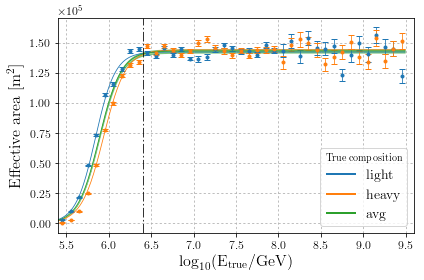

In [34]:
fig, ax = plt.subplots()
# plot effective area data points with poisson errors
ax.errorbar(np.log10(energy_midpoints), eff_area_light, yerr=eff_area_error_light,
            ls='None', marker='.')
ax.errorbar(np.log10(energy_midpoints), eff_area_heavy, yerr=eff_area_error_heavy,
            ls='None', marker='.')

# plot corresponding sigmoid fits to effective area
x = 10**np.arange(5.0, 9.5, 0.01)
ax.plot(np.log10(x), sigmoid_flat(x, *popt_light),
        color=color_dict['light'], label='light', marker='None')
ax.plot(np.log10(x), sigmoid_flat(x, *popt_heavy),
        color=color_dict['heavy'], label='heavy', marker='None')


avg_eff_area = (sigmoid_flat(x, *popt_light) + sigmoid_flat(x, *popt_heavy)) / 2
ax.plot(np.log10(x), avg_eff_area,
        color=color_dict['total'], label='avg', marker='None')
ax.fill_between(np.log10(x),
        avg_eff_area-0.01*avg_eff_area,
        avg_eff_area+0.01*avg_eff_area,
        color=color_dict['total'], alpha=0.5)

ax.axvline(6.4, marker='None', ls='-.', color='k')

ax.set_ylabel('Effective area [m$^2$]')
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
print(143177.*0.01)
# ax.set_title('$\mathrm{A_{eff} = 143177 \pm 1431.77 \ m^2}$')
ax.grid()
# ax.set_ylim([0, 180000])
ax.set_xlim([5.4, 9.6])

#set label style        
ax.ticklabel_format(style='sci',axis='y')
ax.yaxis.major.formatter.set_powerlimits((0,0))

leg = plt.legend(title='True composition')
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)

plt.savefig('/home/jbourbeau/public_html/figures/effective-area.png')
plt.show()

Effective area as quality cuts are sequentially applied

In [19]:
df_sim, cut_dict_sim = comp.load_dataframe(datatype='sim', config='IC79', return_cut_dict=True)
standard_cut_keys = ['num_hits_1_60', 'IceTopQualityCuts', 'lap_InIce_containment',
#                 'num_hits_1_60', 'max_qfrac_1_60',
                'InIceQualityCuts']
# for cut in ['MilliNCascAbove2', 'MilliQtotRatio', 'MilliRloglBelow2', 'StochRecoSucceeded']:
#     standard_cut_keys += ['InIceQualityCuts_{}'.format(cut)]

eff_area_dict = {}
eff_area_err_dict = {}
selection_mask = np.array([True] * len(df_sim))
for key in standard_cut_keys:
    selection_mask *= cut_dict_sim[key]
    print(key, np.sum(selection_mask))
    eff_area, eff_area_error, _ = comp.analysis.get_effective_area(df_sim[selection_mask],
                                                                energy_bins, energy='MC')
#     eff_area, eff_area_error = comp.analysis.effective_area.effective_area(df_sim[selection_mask],
#                                                                            np.arange(5.0, 9.51, 0.1))
    eff_area_dict[key] = eff_area
    eff_area_err_dict[key] = eff_area_error

num_hits_1_60 397466
Calculating effective area...
Simulation set 7006: 30000 files
Simulation set 7007: 30000 files
Simulation set 7241: 10000 files
Simulation set 7242: 10000 files
Simulation set 7262: 19999 files
Simulation set 7263: 19998 files
Simulation set 7579: 12000 files
Simulation set 7784: 12000 files
Simulation set 7791: 12000 files
Simulation set 7851: 12000 files
IceTopQualityCuts 397466
Calculating effective area...
Simulation set 7006: 30000 files
Simulation set 7007: 30000 files
Simulation set 7241: 10000 files
Simulation set 7242: 10000 files
Simulation set 7262: 19999 files
Simulation set 7263: 19998 files
Simulation set 7579: 12000 files
Simulation set 7784: 12000 files
Simulation set 7791: 12000 files
Simulation set 7851: 12000 files
lap_InIce_containment 308874
Calculating effective area...
Simulation set 7006: 30000 files
Simulation set 7007: 30000 files
Simulation set 7241: 10000 files
Simulation set 7242: 10000 files
Simulation set 7262: 19999 files
Simulation

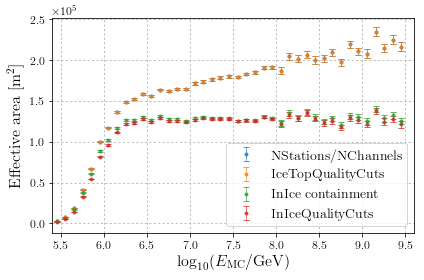

In [20]:
fig, ax = plt.subplots()
cut_labels = {'num_hits_1_60': 'NStations/NChannels', 'IceTopQualityCuts': 'IceTopQualityCuts',
             'lap_InIce_containment': 'InIce containment', 'InIceQualityCuts': 'InIceQualityCuts'}
for key in standard_cut_keys:
# plot effective area data points with poisson errors
    ax.errorbar(np.log10(energy_midpoints), eff_area_dict[key], yerr=eff_area_err_dict[key],
                ls='None', marker='.', label=cut_labels[key], alpha=0.75)

ax.set_ylabel('Effective area [m$^2$]')
ax.set_xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
ax.grid()
# ax.set_ylim([0, 180000])
ax.set_xlim([5.4, 9.6])

#set label style        
ax.ticklabel_format(style='sci',axis='y')
ax.yaxis.major.formatter.set_powerlimits((0,0))

leg = plt.legend()

plt.savefig('/home/jbourbeau/public_html/figures/effective-area-cuts.png')
plt.show()